## Contents:
- [Imports](#Imports)
- [Prepare Dataset](#Prepare-Dataset)
- [Cluster Latitude and Longitude data as location data](#Cluster-Latitude-and-Longitude-data-as-location-data)
- [Bootstrap](#Bootstrap)
- [One Hot Encode Features](#One-Hot-Encode-Features)
- [Create X, y and Train, Test](#Create-X,-y-and-Train,-Test)
- [Standardize Data](#Standardize-Data)
- [OPTION: Add polynomial features to capture non-linear relationships](#OPTION:-Add-polynomial-features-to-capture-non-linear-relationships)
- [OPTION: Principle Component Analysis to reduce dimensionality of features](#OPTION:-Principle-Component-Analysis-to-reduce-dimensionality-of-features)
- [Model Network Topology](#Model-Network-Topology)
- [Compile and Fit Neural Network](#Compile-and-Fit-Neural-Network)
- [Save Trained Model](#Save-Trained-Model)
- [Evaluate Model Performance](#Evaluate-Model)

## Overview

This notebook explores a multi-classification neural network. To prepare the dataset several steps are taken and explored including: bootstrapping data, one hot encoding model features, standard scaling of features, addition of polynomial features, and principal component analysis. This model is the best performing in terms of recall, the true positive rate and captures large fires in addition to small fires. 


# Imports

In [25]:
# Import libraries.
import boto3
import io
import pandas as pd
import numpy as np
np.random.seed(42) 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.cluster import KMeans
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, f1_score, make_scorer, precision_score

# Prepare Dataset

### Read raw dataset from AWS

In [89]:
model_df = pd.read_csv('s3://git-to-amazon-s3-outputbucket-rorni8oehk4l/soulclimberchick/meteorology-fire-impact/data-files/mfi_df_yr_trail.csv')
model_df.dropna(inplace=True)
# model_df = pd.read_csv('./data/mfi_df_yr_latlong.csv')


# Drop Unnamed: 0
model_df.drop('Unnamed: 0', axis=1, inplace=True)

#examine
model_df.head(3)

,fire_code,fire_name,complex_name,stat_cause_code,stat_cause_descr,fire_size,fire_size_class,latitude,longitude,state,...,pcp_t9m,pcp_t12m,pmdi_t3m,pmdi_t6m,pmdi_t9m,pmdi_t12m,pdsi_t3m,pdsi_t6m,pdsi_t9m,pdsi_t12m
3469,C781,PACIFIC,NO_NAME,5.0,Debris Burning,0.1,A,32.7167,-114.5008,AZ,...,1.332222,1.5125,2.73,3.62,3.715556,3.203333,3.463333,4.101667,4.036667,3.444167
3470,C428,SANTEFEGAS,NO_NAME,13.0,Missing/Undefined,5.0,B,33.2000,-112.5340,AZ,...,1.332222,1.5125,2.73,3.62,3.715556,3.203333,3.463333,4.101667,4.036667,3.444167
3474,C426,JOSHUATREE,NO_NAME,9.0,Miscellaneous,0.1,A,33.8667,-112.3841,AZ,...,1.872222,1.8375,3.95,3.89,4.140000,3.655833,4.393333,4.371667,4.461111,3.896667


#### Baseline

In [90]:
model_df['fire_size_class'].value_counts(normalize = True)

A    0.615586
B    0.272828
C    0.059007
D    0.017875
E    0.014640
F    0.012505
G    0.007558
Name: fire_size_class, dtype: float64

# Cluster Latitude and Longitude data as location data

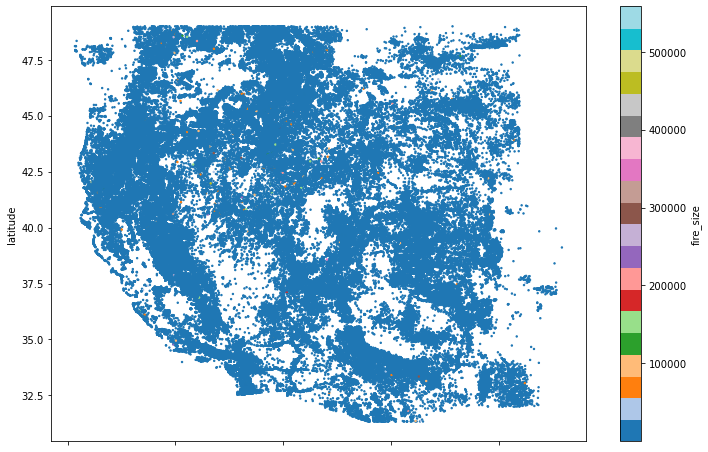

In [50]:
# Where are the fires?
model_df.plot(kind="scatter", x="longitude", y="latitude", c="fire_size",
         cmap="tab20", figsize=(12, 8), s=2);

In [51]:
# Let's scoop lat/long up in a matrix so we can use them easily
location_data = round(model_df[['longitude', 'latitude']],4) # round to decrease grid accuracy of lat/long

# Let's cluster our observations by lat/long: how many clusters should we use?
km = KMeans(n_clusters=200)
km.fit(location_data)

# Append these clusters back onto model_df
model_df.loc[:, 'cluster'] = km.predict(location_data)

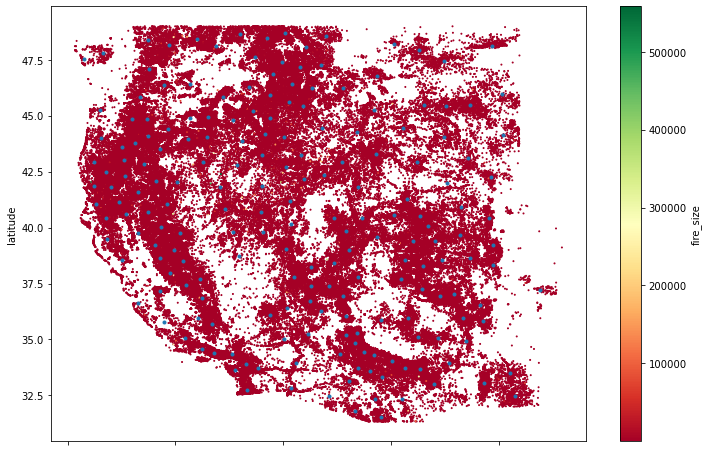

In [52]:
# What do these clusters look like visually?
model_df.plot(kind='scatter', x='longitude', y='latitude',
              c='fire_size',
              #c=km.labels_,
              s=1, cmap="RdYlGn",
             figsize=(12, 8));
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], 
            marker='.')
            #cmap = 'RdYlGn');
# for nums, longlat in enumerate(zip(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1])):
#     plt.text(longlat[0]-.02, longlat[1]+.001, str(nums), color="k", fontsize=16)

# Bootstrap

In [53]:
#credit to Marta
model_df = pd.concat([model_df, 
                                 model_df[model_df['fire_size_class'] == 'C'].sample(n = 100000, replace = True, random_state=42),
                                 model_df[model_df['fire_size_class'] == 'D'].sample(n = 100000, replace = True, random_state=42),
                                 model_df[model_df['fire_size_class'] == 'E'].sample(n = 100000, replace = True, random_state=42),
                                 model_df[model_df['fire_size_class'] == 'F'].sample(n = 100000, replace = True, random_state=42),
                                 model_df[model_df['fire_size_class'] == 'G'].sample(n = 100000, replace = True, random_state=42)],
                     axis = 0)

# One Hot Encode Features

In [54]:
model_df = pd.get_dummies(model_df, columns=['month'], drop_first=True) # in relation to January
model_df = pd.get_dummies(model_df, columns=['cluster']) # location clustered by lat/long

# Create X, y and Train, Test 

In [55]:
model_df['fire_size_class'].value_counts(normalize = True)

A    0.199052
C    0.154409
D    0.141109
E    0.140063
F    0.139373
G    0.137773
B    0.088220
Name: fire_size_class, dtype: float64

In [56]:
#Make the letters numeric
model_df['fire_size_class_order'] = model_df['fire_size_class']
model_df_ordinal_str_columns = model_df[['fire_size_class_order']]

dict_ordinal = {
    'A': 1,
    'B' : 2,
    'C' : 3,
    'D': 4,
    'E' : 5,
    'F' : 6,
    'G' : 7,
      }

#loop to get the job done
for i in model_df_ordinal_str_columns.columns:
    model_df.replace({i: dict_ordinal},inplace = True)

In [57]:
model_df.columns[170:260]

Index(['cluster_110', 'cluster_111', 'cluster_112', 'cluster_113',
       'cluster_114', 'cluster_115', 'cluster_116', 'cluster_117',
       'cluster_118', 'cluster_119', 'cluster_120', 'cluster_121',
       'cluster_122', 'cluster_123', 'cluster_124', 'cluster_125',
       'cluster_126', 'cluster_127', 'cluster_128', 'cluster_129',
       'cluster_130', 'cluster_131', 'cluster_132', 'cluster_133',
       'cluster_134', 'cluster_135', 'cluster_136', 'cluster_137',
       'cluster_138', 'cluster_139', 'cluster_140', 'cluster_141',
       'cluster_142', 'cluster_143', 'cluster_144', 'cluster_145',
       'cluster_146', 'cluster_147', 'cluster_148', 'cluster_149',
       'cluster_150', 'cluster_151', 'cluster_152', 'cluster_153',
       'cluster_154', 'cluster_155', 'cluster_156', 'cluster_157',
       'cluster_158', 'cluster_159', 'cluster_160', 'cluster_161',
       'cluster_162', 'cluster_163', 'cluster_164', 'cluster_165',
       'cluster_166', 'cluster_167', 'cluster_168', 'cluster_1

In [68]:
## create X and y variables

## WITH STATE CODE

# X = model_df[[ 'pcp', 'tavg', 'pdsi', 'phdi', 'zndx', 'pmdi', 'sp02',
#        'sp03', 'sp06', 'sp09', 'sp12', 'sp24', 'tmin', 'tmax', 'month_2', 'month_3',
#        'month_4', 'month_5', 'cdd', 'hdd','month_6', 'month_7', 'month_8', 'month_9',
#        'month_10', 'month_11', 'month_12','statecode_4', 'statecode_5', 'statecode_10',
#        'statecode_24', 'statecode_26', 'statecode_29', 'statecode_35',
#        'statecode_45', 'statecode_110']]

## WITH LAT/LONG
X = model_df[[ 'pcp', 'tavg', 'pdsi', 'phdi', 'zndx', 'pmdi', 'sp02',
       'sp03', 'sp06', 'sp09', 'sp12', 'sp24', 'tmin', 'tmax', 'month_2', 'month_3',
       'month_4', 'month_5', 'cdd', 'hdd','month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'cluster_0', 'cluster_1', 'cluster_2',
       'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 
       'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11',
       'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16',
       'cluster_17', 'cluster_18', 'cluster_19', 'cluster_20', 'cluster_21',
       'cluster_22', 'cluster_23', 'cluster_24', 'cluster_25', 'cluster_26',
       'cluster_27', 'cluster_28', 'cluster_29', 'cluster_30', 'cluster_31',
       'cluster_32', 'cluster_33', 'cluster_34', 'cluster_35', 'cluster_36',
       'cluster_37', 'cluster_38', 'cluster_39', 'cluster_40', 'cluster_41',
       'cluster_42', 'cluster_43', 'cluster_44', 'cluster_45', 'cluster_46',
       'cluster_47', 'cluster_48', 'cluster_49', 'cluster_50', 'cluster_51',
       'cluster_52', 'cluster_53', 'cluster_54', 'cluster_55', 'cluster_56',
       'cluster_57', 'cluster_58', 'cluster_59', 'cluster_60', 'cluster_61',
       'cluster_62', 'cluster_63', 'cluster_64', 'cluster_65', 'cluster_66',
       'cluster_67', 'cluster_68', 'cluster_69', 'cluster_70', 'cluster_71',
       'cluster_72', 'cluster_73', 'cluster_74', 'cluster_75', 'cluster_76',
       'cluster_77', 'cluster_78', 'cluster_79', 'cluster_80', 'cluster_81',
       'cluster_82', 'cluster_83', 'cluster_84', 'cluster_85', 'cluster_86',
       'cluster_87', 'cluster_88', 'cluster_89', 'cluster_90', 'cluster_91',
       'cluster_92', 'cluster_93', 'cluster_94', 'cluster_95', 'cluster_96',
       'cluster_97', 'cluster_98', 'cluster_99', 'cluster_100', 'cluster_101',
       'cluster_102', 'cluster_103', 'cluster_104', 'cluster_105',
       'cluster_106', 'cluster_107', 'cluster_108', 'cluster_109',
       'cluster_110', 'cluster_111', 'cluster_112', 'cluster_113',
       'cluster_114', 'cluster_115', 'cluster_116', 'cluster_117',
       'cluster_118', 'cluster_119', 'cluster_120', 'cluster_121',
       'cluster_122', 'cluster_123', 'cluster_124', 'cluster_125',
       'cluster_126', 'cluster_127', 'cluster_128', 'cluster_129',
       'cluster_130', 'cluster_131', 'cluster_132', 'cluster_133',
       'cluster_134', 'cluster_135', 'cluster_136', 'cluster_137',
       'cluster_138', 'cluster_139', 'cluster_140', 'cluster_141',
       'cluster_142', 'cluster_143', 'cluster_144', 'cluster_145',
       'cluster_146', 'cluster_147', 'cluster_148', 'cluster_149',
       'cluster_150', 'cluster_151', 'cluster_152', 'cluster_153',
       'cluster_154', 'cluster_155', 'cluster_156', 'cluster_157',
       'cluster_158', 'cluster_159', 'cluster_160', 'cluster_161',
       'cluster_162', 'cluster_163', 'cluster_164', 'cluster_165',
       'cluster_166', 'cluster_167', 'cluster_168', 'cluster_169',
       'cluster_170', 'cluster_171', 'cluster_172', 'cluster_173',
       'cluster_174', 'cluster_175', 'cluster_176', 'cluster_177',
       'cluster_178', 'cluster_179', 'cluster_180', 'cluster_181',
       'cluster_182', 'cluster_183', 'cluster_184', 'cluster_185',
       'cluster_186', 'cluster_187', 'cluster_188', 'cluster_189',
       'cluster_190', 'cluster_191', 'cluster_192', 'cluster_193',
       'cluster_194', 'cluster_195', 'cluster_196', 'cluster_197',
       'cluster_198', 'cluster_199', 'tavg_t12m',
       'tavg_t9m', 'tavg_t6m', 'tavg_t3m', 'pcp_t12m', 'pcp_t9m', 'pcp_t6m',
       'pcp_t3m', 'pmdi_t12m', 'pmdi_t9m', 'pmdi_t6m', 'pmdi_t3m', 'pdsi_t12m',
       'pdsi_t9m', 'pdsi_t6m', 'pdsi_t3m']]


y = model_df[['fire_size_class_order']]

assert len(X) == len(y)

#split into training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=.2, train_size = .8, stratify = y)

In [69]:
# prepare y for confusion matrix
y_train_con = y_train
y_test_con = y_test

# prepare y for multiclass modeling
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [70]:
y_train.shape

(591150, 8)

# Standardize Data

In [71]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

# OPTION: Add polynomial features to capture non-linear relationships

In [37]:
# transform = PolynomialFeatures(degree=2)
# X_train_sc = transform.fit_transform(X_train_sc)
# X_test_sc = transform.fit_transform(X_test_sc)

# OPTION: Principle Component Analysis to reduce dimensionality of features

Explained variance (first 30 components): [0.058 0.025 0.016 0.013 0.012 0.009 0.006 0.006 0.005 0.005 0.005 0.005
 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004]

Cumulative explained variance (first 30 components): [0.058 0.084 0.099 0.112 0.124 0.132 0.139 0.144 0.15  0.154 0.159 0.164
 0.168 0.172 0.177 0.181 0.185 0.19  0.194 0.198]


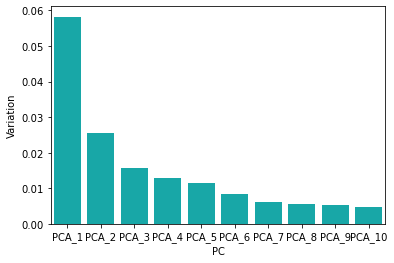

In [65]:
# #NOTE: this method (bootstrap + polynomial features + PCA) increases linear regression r^2 score from .001 to .06 which is a marked improvement. 

# # Instantiate PCA with 100 components.
# pca = PCA(n_components=100, random_state=42)

# # Fit PCA to training data.
# pca.fit(X_train_sc)

# # Transform Z_train and Z_test.
# X_train_sc = pca.transform(X_train_sc)
# X_test_sc = pca.transform(X_test_sc)

# # Pull the explained variance attribute.
# var_exp = pca.explained_variance_ratio_
# print(f'Explained variance (first 30 components): {np.round(var_exp[:20], 3)}')

# print('')

# # Generate the cumulative explained variance.
# cum_var_exp = np.cumsum(var_exp)
# print(f'Cumulative explained variance (first 30 components): {np.round(cum_var_exp[:20], 3)}')

# columns = [f'PCA_{i+1}' for i in pd.DataFrame(X_train_sc).columns]
# var_ratio_df = pd.DataFrame({'Variation':var_exp,
#              'PC':columns})
# var_ratio_df.head()
# sns.barplot(x=var_ratio_df['PC'].head(10) ,y=var_ratio_df['Variation'].head(10), 
#            data=var_ratio_df, color="c");

In [72]:
# Test with Linear Regression
from sklearn.linear_model import LinearRegression

# Instantiate linear regression model.
lm = LinearRegression()

# Fit on Z_train.
lm.fit(X_train_sc, y_train)

# Score on training and testing sets.
print(f'Training Score: {round(lm.score(X_train_sc, y_train),4)}')
print(f'Testing Score: {round(lm.score(X_test_sc, y_test),4)}')

Training Score: 0.1708
Testing Score: 0.1703


#### Note that regression performs better when using a limited amount of classes instead of the continuous variable acres of land burned. When class is grouped into small, medium, large the R^2 goes up to above 30%. This further illustrates that this problem is best approached with a classifier algorithm instead of a regression algorithm

# Model Network Topology

In [73]:
#instantiate model
model = Sequential()

#input layer
n_input = X_train_sc.shape[1]

#dense layers
model.add(Dense(n_input, 
                input_dim=n_input,
                activation='relu',
                kernel_regularizer=l2(0.001)))
model.add(Dense(128, 
                input_dim=n_input,
                activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, 
                input_dim=n_input,
                activation='relu',
                ))
model.add(Dropout(0.2))

#output layer
model.add(Dense(8, activation='softmax'))

# Compile and Fit Neural Network

### Compile

In [74]:
#compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Fit

In [75]:
#fit model to dataset
history = model.fit(X_train_sc, y_train, validation_data=(X_test_sc, y_test), epochs=50, batch_size=64, workers = -2)

Epoch 1/50
9237/9237 [==============================] - 38s 4ms/step - loss: 1.8626 - accuracy: 0.2953 - val_loss: 1.6827 - val_accuracy: 0.3726
Epoch 2/50
9237/9237 [==============================] - 29s 3ms/step - loss: 1.6920 - accuracy: 0.3697 - val_loss: 1.6039 - val_accuracy: 0.4103
Epoch 3/50
9237/9237 [==============================] - 28s 3ms/step - loss: 1.6298 - accuracy: 0.4044 - val_loss: 1.5495 - val_accuracy: 0.4396
Epoch 4/50
9237/9237 [==============================] - 28s 3ms/step - loss: 1.5961 - accuracy: 0.4188 - val_loss: 1.5280 - val_accuracy: 0.4491
Epoch 5/50
9237/9237 [==============================] - 27s 3ms/step - loss: 1.5734 - accuracy: 0.4297 - val_loss: 1.5042 - val_accuracy: 0.4587
Epoch 6/50
9237/9237 [==============================] - 27s 3ms/step - loss: 1.5577 - accuracy: 0.4365 - val_loss: 1.4894 - val_accuracy: 0.4650
Epoch 7/50
9237/9237 [==============================] - 26s 3ms/step - loss: 1.5461 - accuracy: 0.4420 - val_loss: 1.4807 - val_ac

# Save Trained Model

In [76]:
model.save('./models/200_cluster_50epochs_trailingavg') #UNCOMMENT TO SAVE MODEL

INFO:tensorflow:Assets written to: 200_cluster_50epochs_trailingavg\assets


### Load Model

In [77]:
model = tf.keras.models.load_model('./models/200_cluster_50epochs_trailingavg') #UNCOMMENT TO LOAD MODEL

# Check its architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 243)               59292     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               31232     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 520       
Total params: 99,300
Trainable params: 99,300
Non-trainable params: 0
____________________________________________________

# Evaluate Model Performance

### Model loss

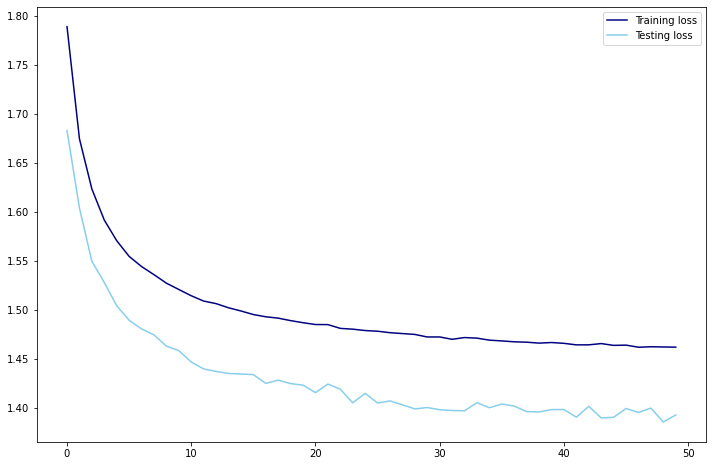

In [78]:
# Visualize loss
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

### Accuracy

In [79]:
history.history['accuracy'][-1],history.history['val_accuracy'][-1]

(0.4743753671646118, 0.50169837474823)

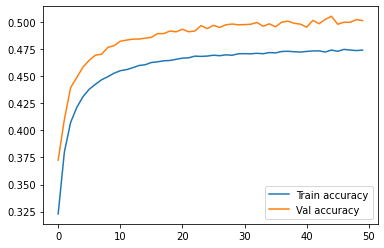

In [80]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend();

### Recall

In [81]:
#[None, 'micro', 'macro', 'weighted']
recall_score(y_test_con, model.predict_classes(X_test_sc), average = None)

C:\Users\jesse\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0.59166468, 0.0069796 , 0.19719544, 0.50345258, 0.57903382,
       0.59030003, 0.85973184])

### Confusion Matrix

In [82]:
y_pred=model.predict_classes(X_test_sc)

In [83]:
con_mat = tf.math.confusion_matrix(labels=y_test_con, predictions=y_pred).numpy()

In [84]:
classes = ['0', 'A', 'B', 'C', 'D', 'E', 'F', 'G']
#classes = ['0', 'Small', 'Medium', 'Big']

In [85]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

con_mat_df_values = pd.DataFrame(con_mat,
                     index = classes, 
                     columns = classes)

<ipython-input-85-5f2801a7b30b>:1: RuntimeWarning: invalid value encountered in true_divide
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)


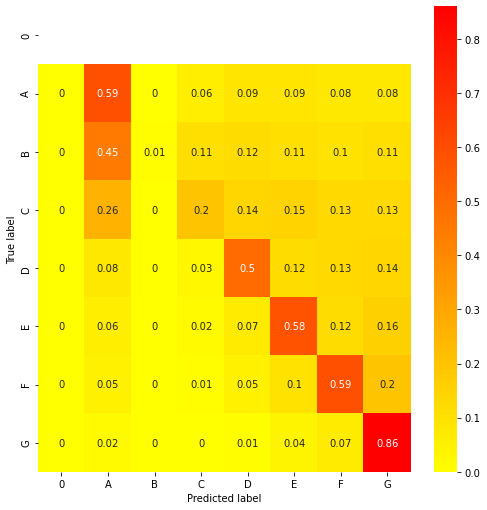

In [86]:
figure = plt.figure(figsize=(7, 7))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.autumn_r)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('./visuals/confusion_matrix_fire.png', transparent=True)
plt.show()

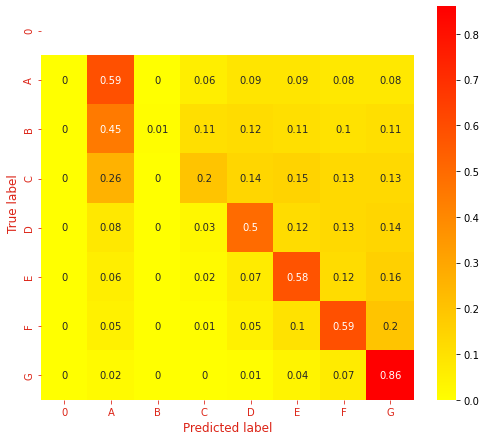

In [88]:
figure = plt.figure(figsize=(7, 6))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.autumn_r)
plt.tight_layout()
plt.ylabel('True label',fontsize=12, color='#dc2417')
plt.xlabel('Predicted label', fontsize=12, color='#dc2417')
plt.xticks(fontsize=10, color='#dc2417')
plt.yticks(fontsize=10, color='#dc2417')
plt.tick_params(color='#dc2417')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False);
#plt.show()
plt.savefig('./visuals/nn_confusion_matrix.png', transparent=True, bbox_inches='tight')